_Version log: Finding the best samples though brute force and manual tweaking. Also started to compare different optimisation results._

In [7]:
import CS_functions as cs
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt, colors as mplcolors
from scipy import fft as spfft
from scipy.constants import speed_of_light as C
plt.rcParams.update({'font.size':24, 'xtick.minor.visible': True, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})
#np.set_printoptions(threshold=sys.maxsize)

In [8]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

In [9]:
file_name = "1dmockanderrors17"
file_type = ".csv"
reduced_points = 15

target, uncertainties = cs.open_dataset(file_name, file_type)
#uncertainties = np.ones_like(uncertainties)
total_points = len(target)
optlocs_file = "data\\" + file_name +"_optlocs.csv"

In [10]:
full_data = cs.open_csv(optlocs_file, reduced_points)

In [11]:
test = [  5,  19,  31,  39,  56,  73,  79,  93, 113, 130, 143, 165, 168, 190, 191] # Manual
#test = cs.subsample_1d(total_points, reduced_points, subsampling_method= "regular") # referance

test = np.array(test)
len(test)

15

In [12]:
full_data = np.vstack([full_data, test])
full_data.shape

(21, 15)

In [13]:
regularization_coeffient = 1e-3

def find_error(locations):
    assert locations.ndim == 1
    locations = locations[~np.isnan(locations)].astype(int)

    samples = np.full_like(target, np.nan)
    samples[locations] = target[locations]
    result = cs.compressed_sensing(samples, regularization_coeffient)
    error = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

    return error

errors = [find_error(locations) for locations in tqdm(full_data)]
errors = np.array(errors)


 29%|██▊       | 6/21 [00:00<00:00, 52.17it/s]

100%|██████████| 21/21 [00:00<00:00, 38.42it/s]


In [14]:
sort = np.argsort(errors)
print(errors[-1])
errors = errors[sort]
full_data = full_data[sort]

9.129465181515275


In [15]:
print(*zip(errors, full_data), sep= "\n")

(4.379890746621454, array([100,  93,  88,  84, 101,  95, 114, 126, 130, 111, 103,  64,  29,
       154, 199]))
(4.379890746621454, array([100,  93,  88,  84, 101,  95, 114, 126, 130, 111, 103,  64,  29,
       154, 199]))
(4.379890746621454, array([100,  93,  88,  84, 101,  95, 114, 126, 130, 111, 103,  64,  29,
       154, 199]))
(4.379890746621454, array([100,  93,  88,  84, 101,  95, 114, 126, 130, 111, 103,  64,  29,
       154, 199]))
(4.379890746621454, array([100,  93,  88,  84, 101,  95, 114, 126, 130, 111, 103,  64,  29,
       154, 199]))
(6.487219061411117, array([  0, 164,  28,  43,  66,  67,  85, 100,  94, 128,   9, 156,  11,
       185,  99]))
(6.487219061411117, array([  0, 164,  28,  43,  66,  67,  85,  11,  94, 128,   9, 156, 100,
       185,  99]))
(6.487219061411117, array([  0, 164,  28,  43,  66,  67,  85, 100,  11, 128,   9, 156,  94,
       185,  99]))
(6.487219061411117, array([  0, 164,  28,  43,  66,  67,  85, 100,  94, 128,   9, 156,  11,
       185,  99]))
(

In [16]:
sa_error = find_error(test)
brute_errors = np.empty((reduced_points, total_points))

fixed_points = np.repeat(test[None, :], reduced_points, axis= 0)
fixed_points = fixed_points[~np.eye(reduced_points, dtype= bool)] #one of the samples is not fixed
fixed_points = fixed_points.reshape((reduced_points, reduced_points-1)) #tell numpy to stop flattening my array

for n in np.arange(reduced_points):
    trail_samples = np.copy(test)
    for trail_sample in np.arange(total_points):
        trail_samples[n] = trail_sample
        brute_error = find_error(trail_samples) #This is the chi-squared
        brute_errors[n, trail_sample] = brute_error

-2.869205422607493


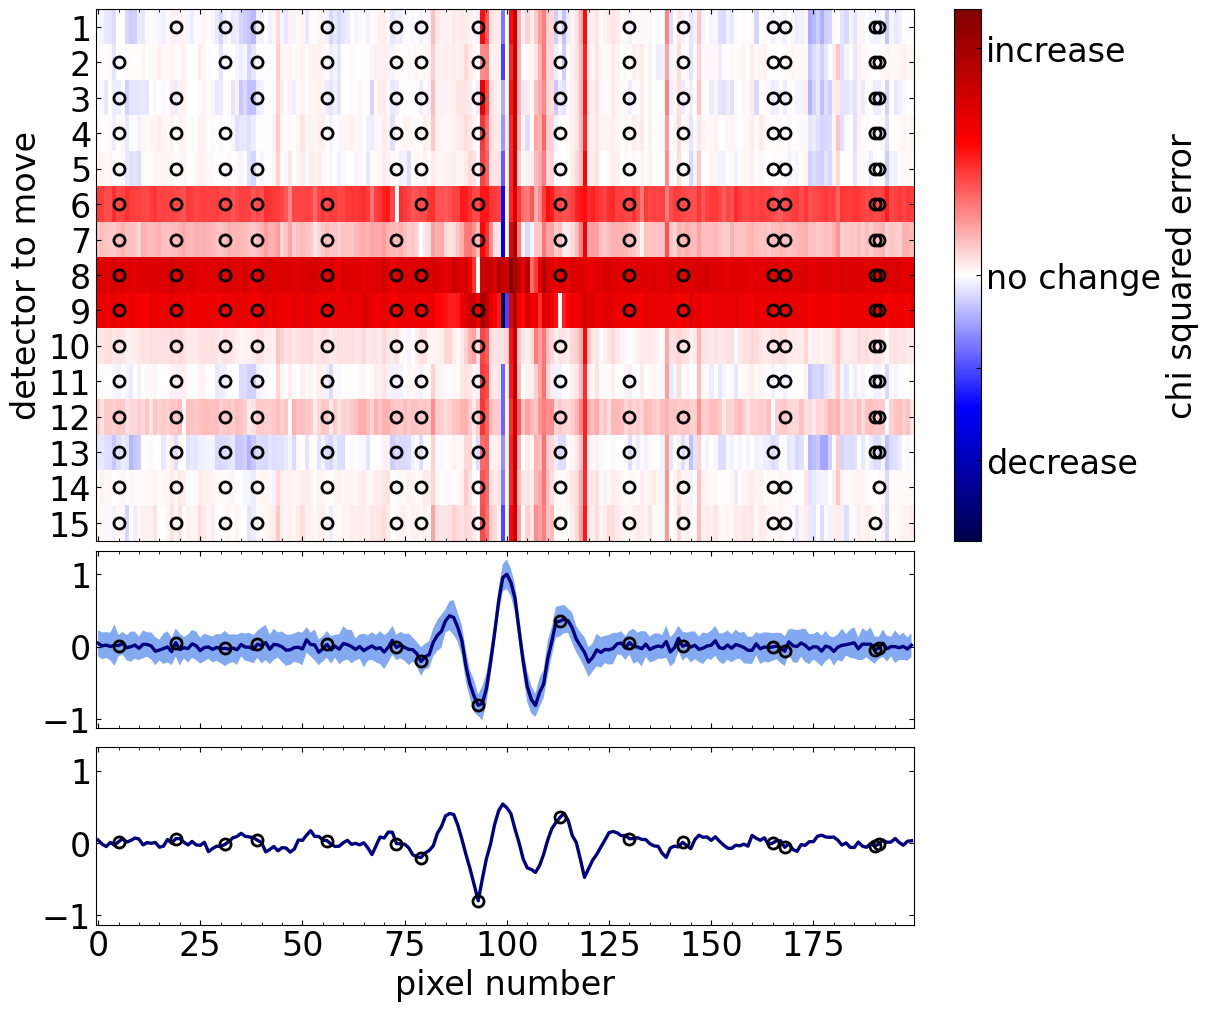

In [17]:
difference = brute_errors -sa_error

max_diff = np.max(difference)
min_diff = np.min(difference)
print(min_diff) # If this is less than zero then SA failed to find the best solution.
if min_diff >= 0: min_diff = -1 #If this is more than or equal to zero then my code breaks!
if max_diff <= 0: max_diff = 1 #If this is less than or equal to zero then my code breaks!

pos_zticks = np.arange(0, max_diff, 10**np.floor(np.log10(np.abs(max_diff))))
neg_zticks = np.arange(0, min_diff, -10**np.floor(np.log10(np.abs(min_diff)))) # np.floor() is NOT the same as int() for negative numbers!
zticks = np.unique(np.concatenate([pos_zticks, neg_zticks]))

zticklabels = np.full_like(zticks, "", dtype= object)
zticklabels[0] = "decrease"
zticklabels[-1] = "increase"
zticklabels[zticks == 0] = "no change"

fig, axs = plt.subplots(3, 1, figsize= (12, 10), sharex= True, height_ratios= (3, 1, 1), layout= "constrained")

norm = mplcolors.TwoSlopeNorm(0, vmin=min_diff, vmax=max_diff) #Greatly exagerates the possible improvements
im = axs[0].imshow(difference, aspect= "auto", interpolation= "none", cmap= "seismic", norm= norm)
cbar = fig.colorbar(im, label= "chi squared error")
cbar.set_ticks(ticks= zticks, labels=zticklabels)

axs[0].plot(fixed_points ,np.arange(reduced_points), linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8) #kind of cursed but it works
axs[0].set(ylabel= "detector to move", yticks= np.arange(reduced_points), yticklabels= np.arange(1, reduced_points+1))

axs[1].plot(target, color= "navy", label= "actual signal")
axs[1].fill_between(range(total_points), target-uncertainties, target+uncertainties, facecolor= "cornflowerblue", alpha= 0.8, label= "± std uncertrainty")
axs[1].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8)

samples = np.full_like(target, np.nan)
samples[test] = target[test]

axs[2].plot(cs.compressed_sensing(samples, regularization_coeffient), color= "navy")
axs[2].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8)
axs[2].set(xlabel= "pixel number", ylim= axs[1].get_ylim())

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_24168\751616233.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


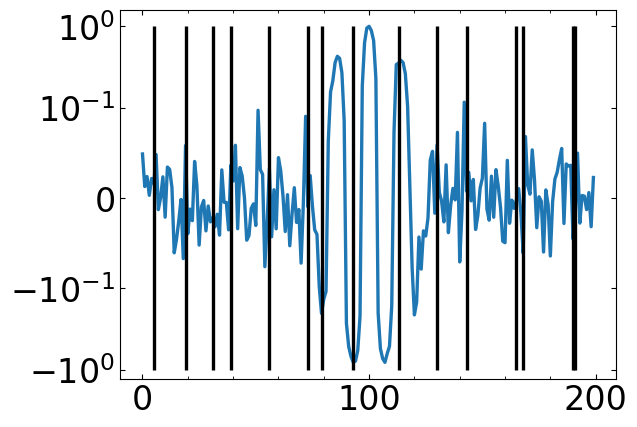

In [18]:
fig, axs = plt.subplots()

axs.plot(target)
axs.set_yscale("symlog", linthresh= 1e-1)
axs.vlines(test, -1, 1, colors= "k")
fig.show()

## COMPARING DIFFERENT RESULTS

In [19]:
cs.subsample_1d(200, 8, "regular")

array([  0,  28,  57,  85, 114, 142, 171, 199])

In [20]:
optimised_detectors = {"Uniform Sampling": [0,  28,  57,  85, 114, 142, 171, 199],
                       "Douglas Peucker": [82,87,93,100,102,103,116,128],
                       "Greedy": [2,57,92,106,114,135,145,164],
                       "MCMC Metropolis": [7,12,39,95,101,121,122,169],
                       "Simulated Annealing": [83,87,94,99,101,102,104,111]}

runtimes = ["1 ms", "200 ms", "2 min", "20 min", "30 min"]
scores = [cs.evaluate_score(sensors, target, uncertainties, regularization_coeffient) for sensors in optimised_detectors.values()]

pixel_pitch = 200 #um
theta = 60 #arcminutes
regularization_coeffient = 1e-3

In [21]:
for method, sensors in optimised_detectors.items():
    print(method, sensors)

Uniform Sampling [0, 28, 57, 85, 114, 142, 171, 199]
Douglas Peucker [82, 87, 93, 100, 102, 103, 116, 128]
Greedy [2, 57, 92, 106, 114, 135, 145, 164]
MCMC Metropolis [7, 12, 39, 95, 101, 121, 122, 169]
Simulated Annealing [83, 87, 94, 99, 101, 102, 104, 111]


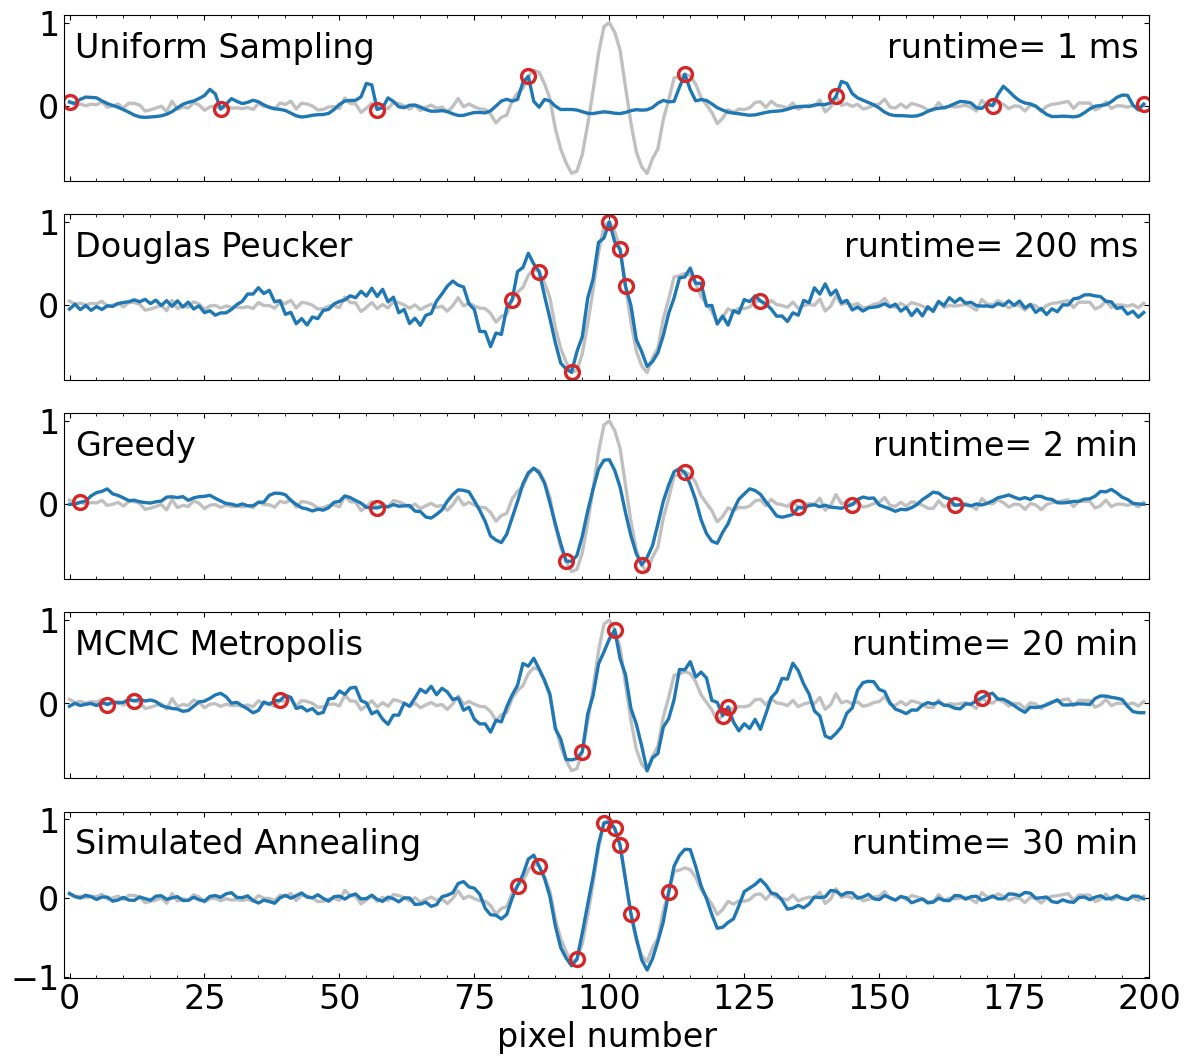

In [22]:
### INTERFEROGRAMS

number_of_methods = len(optimised_detectors)

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.2}, facecolor='none')

for ax, method, sensors, runtime, score in zip(axs, optimised_detectors.keys(), optimised_detectors.values(), runtimes, scores):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient)
    ax.plot(target, color= "silver")
    ax.plot(result)
    ax.plot(sensors, samples[sensors], linestyle= "None", marker= "o", markeredgecolor= "tab:red", markerfacecolor= "None")
    ax.set(xlim= (-1, 200), facecolor='white')
    ax.annotate(method, (0.01,0.9), xycoords= 'axes fraction', ha= "left", va= "top")
    ax.annotate("runtime= {0:s}".format(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")
axs[-1].set(xlabel= "pixel number")

plt.show()

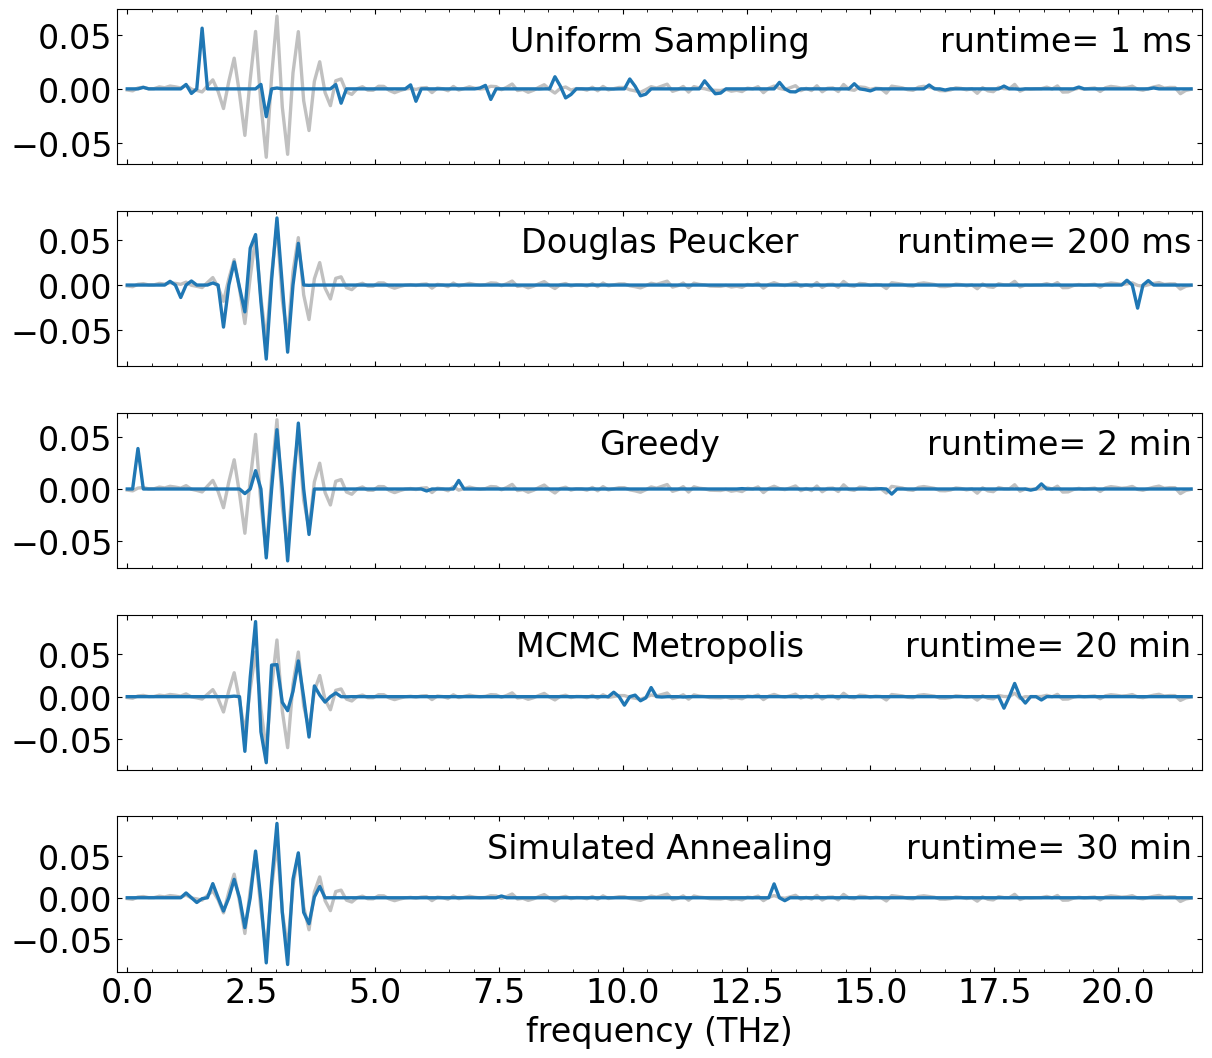

In [23]:
### DCT BASIS

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.3}, facecolor='none')

nyquist = C / (4 *pixel_pitch*1e-6 *np.sin(np.deg2rad(theta/60)))
nyquist *= 1e-12
freqs = np.linspace(0, nyquist, total_points) # THIS IS APPROXIMATE WHEN TOTAL_POINTS IS ODD.

for ax, method, sensors, runtime, score in zip(axs, optimised_detectors.keys(), optimised_detectors.values(), runtimes, scores):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient, domain= "DCT")
    ax.plot(freqs, spfft.dct(target, type= 1, norm= "forward"), color= "silver")
    ax.plot(freqs, result)
    ax.set(xlim= (-0.2, 21.7), facecolor='white')
    ax.annotate(method, (0.5,0.9), xycoords= 'axes fraction', ha= "center", va= "top")
    ax.annotate("runtime= {0:s}".format(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")
axs[-1].set(xlabel= "frequency (THz)")

plt.show()

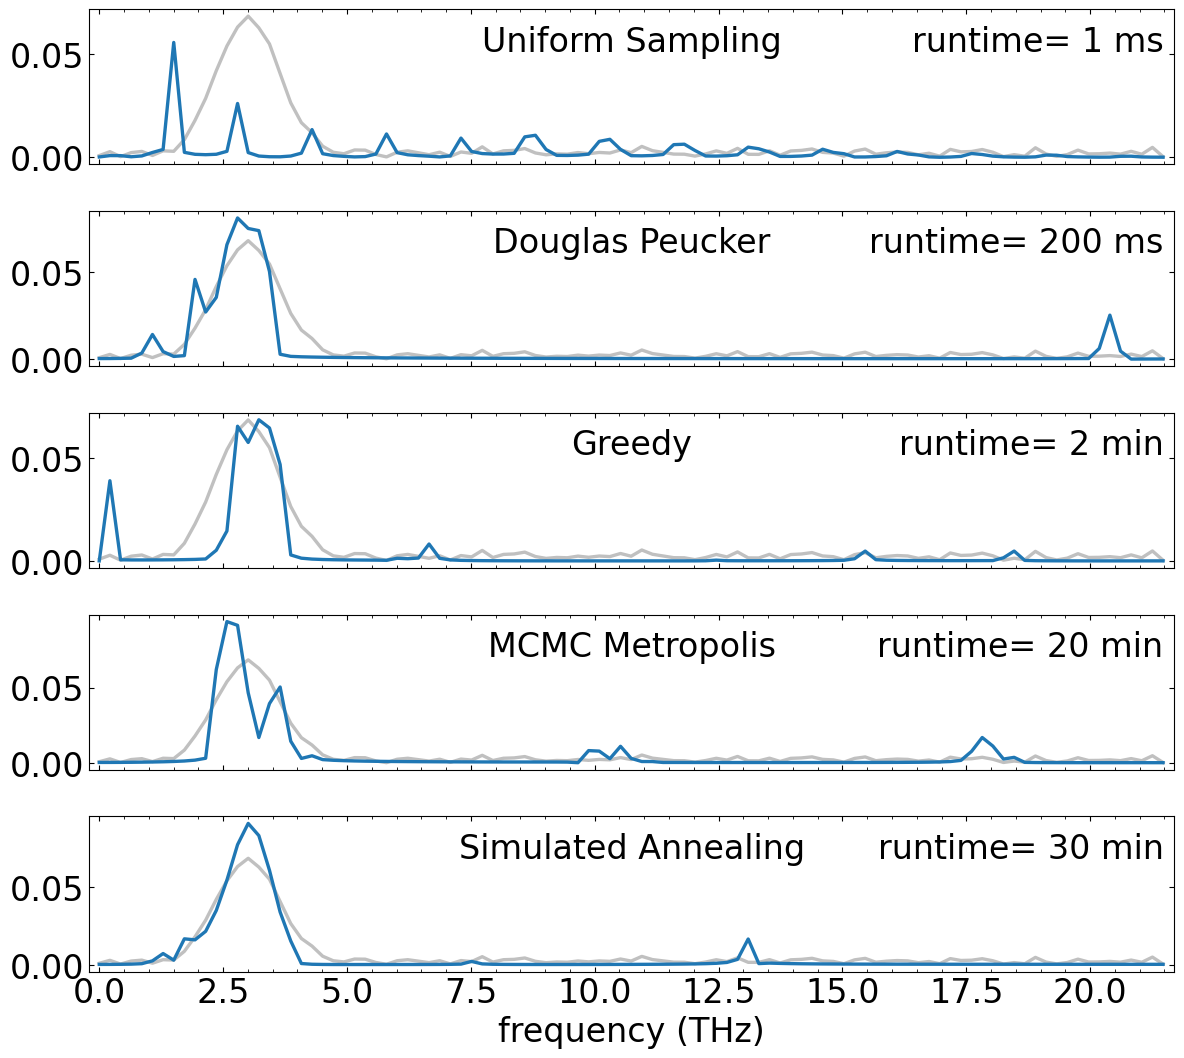

In [24]:
### POWER SPECTRUM

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.3}, facecolor='none')

freqs = np.fft.rfftfreq(200, pixel_pitch*1e-6)
freqs /= 2*np.sin(np.deg2rad(theta/60))
freqs *= C
freqs *= 1e-12

for ax, method, sensors, runtime, score in zip(axs, optimised_detectors.keys(), optimised_detectors.values(), runtimes, scores):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient)
    ax.plot(freqs, np.abs(np.fft.rfft(target, norm= "forward")), color= "silver")
    ax.plot(freqs, np.abs(np.fft.rfft(result, norm= "forward")))
    ax.set(xlim= (-0.2, 21.7), facecolor='white')
    ax.annotate(method, (0.5,0.9), xycoords= 'axes fraction', ha= "center", va= "top")
    ax.annotate("runtime= {0:s}".format(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")
axs[-1].set(xlabel= "frequency (THz)")

plt.show()